In [49]:
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import pandas as pd

import neatnet

In [40]:
#place = "Milton Keynes"
#local_crs = 27700

#boolean to have different fucnitons enbaled/disabled/ // centrality, blocks, ... 

dist = 5000

place = "Barcelona"
local_crs =  25831
Barc_coord = (41.381426, 2.173053)

place = "Athens"
local_crs = 2100
Ath_coord= (37.989702027509686, 23.738142824327344)

place = "Tokyo"
Tok_coord = (35.702950, 139.769753)

place = "loughborough"
lbrgh_coord = (52.767225, -1.220030)

Downloaded street network for (41.381426, 2.173053)


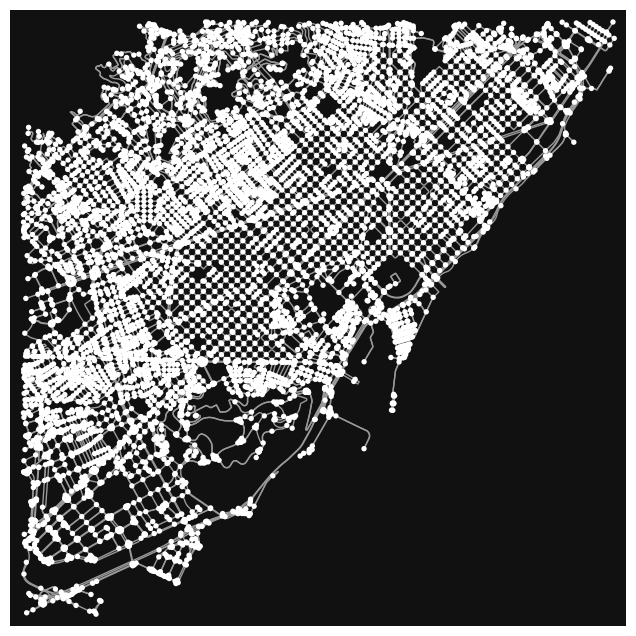

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [41]:
center_point = Barc_coord
network_type = 'drive' # "all_public", "all", "bike", "drive", "drive_service", "walk"
custom_filter = (
    '["highway"~"motorway|trunk|primary|secondary|tertiary|footway|pedestrian|path|steps"]'
)

osm_graph=ox.graph.graph_from_point(
    center_point, dist, 
    dist_type='bbox', 
    network_type=network_type, 
    simplify=True, 
    retain_all=False, 
    truncate_by_edge=False, 
    custom_filter=None)

print(f"Downloaded street network for {center_point}")

ox.plot_graph(osm_graph)

In [42]:

osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)

streets = ox.graph_to_gdfs(
    ox.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)

In [36]:
buildings = (
    ox.features.features_from_point(
        center_point=center_point,
        dist=dist,
        tags={"building": True}
    )
    .query('building != "roof"')
    .to_crs(local_crs)
)

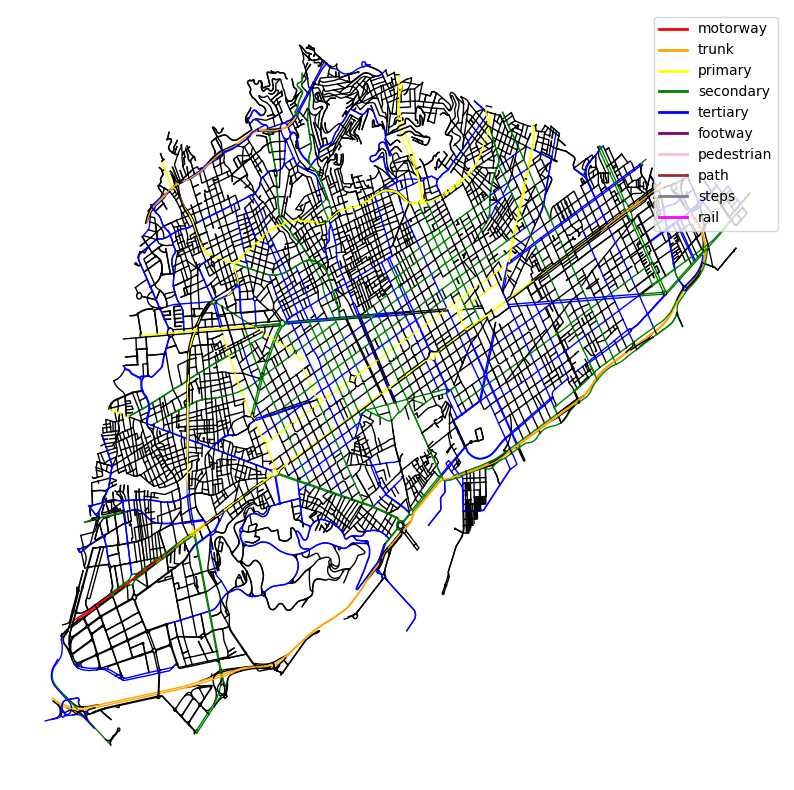

In [43]:
#ax = streets.plot(figsize=(12, 12), linewidth=0.5, color='black')  # black streets
#buildings.plot(ax=ax, facecolor='lightgrey', edgecolor='grey', alpha=0.7)
#ax.set_axis_off()


road_colors = {
    'motorway': 'red',
    'trunk': 'orange',
    'primary': 'yellow',
    'secondary': 'green',
    'tertiary': 'blue',
    'footway': 'purple',
    'pedestrian': 'pink',
    'path': 'brown',
    'steps': 'gray',
    'rail': 'magenta'
}
edges = ox.graph_to_gdfs(osm_graph, nodes=False, edges=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each road and plot with its color
for idx, row in edges.iterrows():
    # Sometimes highway is a list, sometimes a string
    highway_type = row['highway']
    if isinstance(highway_type, list):
        highway_type = highway_type[0]  # take the first one

    color = road_colors.get(highway_type, 'black')  # default to black if not found
    g = row['geometry']
    if g is not None:
        if g.geom_type == 'LineString':
            ax.plot(*g.xy, color=color, linewidth=1)
        elif g.geom_type == 'MultiLineString':
            for linestring in g:
                ax.plot(*linestring.xy, color=color, linewidth=1)

# Set axis off
ax.axis('off')

# Optional: add a legend manually
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=road_type)
    for road_type, color in road_colors.items()
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

# Centrality

In [47]:
def compute_edge_betweenness_centrality(osm_graph):
    """
    Compute edge betweenness centrality and return it merged with the OSM edge GeoDataFrame.
    """

    # Convert to undirected (NetworkX handles this for MultiDiGraph)
    G_undirected = nx.Graph()
    for u, v, data in osm_graph.edges(data=True):
        # Use tuple as key to avoid overwriting parallel edges (basic approach)
        G_undirected.add_edge(u, v, **data)

    # Compute edge betweenness centrality
    edge_centrality = nx.edge_betweenness_centrality(G_undirected, weight='length')

    # Convert to a DataFrame for merging
    centrality_df = pd.DataFrame([
        {'u': u, 'v': v, 'centrality': c}
        for (u, v), c in edge_centrality.items()
    ])

    # Create the GeoDataFrame of edges again to ensure consistent merge
    edges = ox.graph_to_gdfs(
        G_undirected, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True
    ).reset_index()

    # Merge using both directions (since undirected edges may have u,v or v,u)
    merged = pd.merge(edges, centrality_df, on=['u', 'v'], how='left')
    if merged['centrality'].isnull().any():
        # Try merging in reverse for unmatched edges
        centrality_df_rev = centrality_df.rename(columns={'u': 'v', 'v': 'u'})
        merged = pd.merge(merged, centrality_df_rev, on=['u', 'v'], how='left', suffixes=('', '_rev'))
        merged['centrality'] = merged['centrality'].fillna(merged['centrality_rev'])
        merged.drop(columns=['centrality_rev'], inplace=True)

    return merged

In [50]:
centrality_result = compute_edge_betweenness_centrality(osm_graph)

# Filter top 10% most central streets
top_edges = centrality_result[
    centrality_result['centrality'] > centrality_result['centrality'].quantile(0.9)
]

KeyError: 'crs'

In [ ]:
def plot_edge_centrality(osm_graph, centrality_gdf, column='centrality', cmap='plasma', figsize=(12, 12), alpha=0.8):
    """
    Plot the street network with edge centrality values.
    
    Parameters:
        osm_graph: The original OSMnx graph (projected).
        centrality_gdf: GeoDataFrame with 'centrality' column and geometry.
        column: Name of the centrality column to visualize.
        cmap: Color map to use.
        figsize: Size of the plot.
        alpha: Line transparency.
    """
    fig, ax = plt.subplots(figsize=figsize)
    centrality_gdf.plot(
        ax=ax,
        linewidth=1,
        column=column,
        cmap=cmap,
        legend=True,
        alpha=alpha,
    )
    ax.set_title(f"Edge {column.replace('_', ' ').title()} Centrality", fontsize=16)
    ax.axis('off')
    plt.show()

In [ ]:
plot_edge_centrality(osm_graph, centrality_result)

In [38]:
simplified = neatnet.neatify(streets, exclusion_mask=buildings.geometry)

ValueError: Length of values (3) does not match length of index (2)

In [ ]:
ax = streets.plot(figsize=(12, 12), linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=ax)
ax.set_axis_off()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

streets.plot(ax=axs[0], linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=axs[1])
for ax in axs:
    ax.set_xlim(city_centre[0] - 500, city_centre[0] + 500)
    ax.set_ylim(city_centre[1] - 500, city_centre[1] + 500)
    ax.set_axis_off()
axs[0].set_title("original")
axs[1].set_title("simplifiied");

In [ ]:
ax = simplified.plot("_status", figsize=(12, 12), linewidth=0.5, legend=True)
ax.set_axis_off()